In [2]:
from numpy.random import normal
from math import sqrt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import os
from torch.autograd import Variable
import torch.utils.data as Data
from torch.utils.data import Dataset
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import torchvision
import warnings
torch.set_default_tensor_type(torch.FloatTensor)
import copy
import random
warnings.filterwarnings("ignore")

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

setup_seed(20)

In [4]:
MSE=nn.MSELoss()


def IoUAcc(inputs, targets, smooth=1,act='Sigmoid'):
    if act=='Sigmoid':
        threshold=0.5
    if act=='Tanh':
        threshold=0
    inputs = inputs.cpu().detach().view(-1).numpy()
    targets = targets.cpu().detach().view(-1).numpy()        
    inputs=(inputs>threshold).astype(np.int32)
    targets=(targets>threshold).astype(np.int32)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
        
    IoU = (intersection + smooth)/(union + smooth)
                
    return IoU

In [5]:
def make_txt_file(path):
    
    # Classes: train, eval, test
    img_path=os.path.join(path,'TrainVal_images')
    label_path=os.path.join(path,'TrainVal_parsing_annotations')
    train_data=open('train.txt', 'w')
    eval_data=open('eval.txt','w')
    test_data=open('test.txt','w')
    train_data.truncate()
    eval_data.truncate()
    test_data.truncate()
    train_id=open(os.path.join(path,'train_id.txt'))
    val_id=open(os.path.join(path,'val_id.txt'))
    
    train_data_path=os.path.join(img_path,'train_images')
    val_data_path=os.path.join(img_path,'val_images')
    train_label_path=os.path.join(label_path,'train_segmentations')
    val_label_path=os.path.join(label_path,'val_segmentations')
    
    lines=train_id.readlines()
    count=0
    for line in lines:
        
        line=line.strip()
        name=os.path.join(train_data_path,line+'.jpg')+'*'+os.path.join(train_label_path,line+'.png')+'\n'
        train_data.write(name)
        count+=1
        
        if count>=2000:
            break
    train_data.close()
    train_id.close()
    
    lines=val_id.readlines()
    s=0
    count=0
    for line in lines:
        line=line.strip()
        name=os.path.join(val_data_path,line+'.jpg')+'*'+os.path.join(val_label_path,line+'.png')+'\n'
        if s%2==0:
            eval_data.write(name)
        else:
            test_data.write(name)
        s+=1
        
        count+=1
        if count>=1200:
            break
            
    val_id.close() 
    eval_data.close()
    test_data.close()
                


In [6]:
class MyDataSet(Dataset):
    def __init__(self, dataset_type, transform=None,update_dataset=False):
        """
        dataset_type: [train, eval, test]
        """
 
        dataset_path = '/kaggle/input/pil-data/LIP'
        read_path=''
 
        if update_dataset:
            make_txt_file(dataset_path) 
 
        self.transform = transform
        self.sample_list = list()
        self.dataset_type = dataset_type
        f = open(os.path.join(read_path , self.dataset_type + '.txt'))
        lines = f.readlines()
        for line in lines:
            self.sample_list.append(line.strip())
        f.close()
 
    def __getitem__(self, index):
        item = self.sample_list[index]
        img = Image.open(item.split('*')[0]).convert('RGB')       
        label = Image.open(item.split('*')[1]).convert('L')
        
        if self.transform is not None:
            img,label = self.transform(img,label)
           
        return img, label
 
    def __len__(self):
        return len(self.sample_list)

In [7]:
def train_transform1(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))  
    if np.random.rand()>0.7:
        data=transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1)(data)
    if np.random.rand()>0.5:
        data=transforms.functional.hflip(data)
        label=transforms.functional.hflip(label)
    if np.random.rand()>0.8:
        data=transforms.functional.vflip(data)
        label=transforms.functional.vflip(label)
    

    data=transforms.functional.to_tensor(data).float()
    
    label=np.array(label)
    label=(label>=1).astype(int) 
    label=transforms.functional.to_tensor(label).float()
    return data,label

def train_transform2(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))  
    if np.random.rand()>0.7:
        data=transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1)(data)
    if np.random.rand()>0.5:
        data=transforms.functional.hflip(data)
        label=transforms.functional.hflip(label)
    if np.random.rand()>0.8:
        data=transforms.functional.vflip(data)
        label=transforms.functional.vflip(label)
    

    data=transforms.functional.to_tensor(data).float()
    
    label=np.array(label)
    label=(label>=1).astype(int) 

    label=label*2-1
    label=transforms.functional.to_tensor(label).float()
    return data,label

train_transform=[train_transform1,train_transform2]

def test_transform1(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))
    data=transforms.functional.to_tensor(data).float()

    label=np.array(label)
    label=(label>=1).astype(int) 
    label=transforms.functional.to_tensor(label).float()
    return data,label

def test_transform2(data,label):
    data=transforms.functional.resize(data,(256,256))
    label=transforms.functional.resize(label,(256,256))
    data=transforms.functional.to_tensor(data).float()

    label=np.array(label)
    label=(label>=1).astype(int) 

    label=label*2-1
    label=transforms.functional.to_tensor(label).float()
    return data,label

test_transform=[test_transform1,test_transform2]   

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, input):        
        return self.conv(input)

In [9]:
class UNet(nn.Module):
    def __init__(self,colordim =1,activation=None):
        super(UNet, self).__init__()
        self.conv1=DoubleConv(3,32)
        self.conv2=DoubleConv(32,64)
        self.conv3=DoubleConv(64,128)
        self.conv4=DoubleConv(128,256)
        
        self.conv5=DoubleConv(256,512)
        self.upconv5=nn.Conv2d(512, 256, 1)
        
        self.conv6=DoubleConv(512,256)
        self.upconv6=nn.Conv2d(256, 128, 1)
        self.conv7=DoubleConv(256,128)
        self.upconv7=nn.Conv2d(128,64, 1)
        self.conv8=DoubleConv(128,64)
        self.upconv8=nn.Conv2d(64,32, 1)
        self.conv9=DoubleConv(64,32)
        
        self.maxpool=nn.MaxPool2d(2, stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        
        if activation is not None:
            self.output=nn.Sequential(
                nn.Conv2d(32, colordim, 1),
                activation
            )
        else:
            self.output=nn.Conv2d(32, colordim, 1)
        self._initialize_weights()
    
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(self.maxpool(x1))
        x3=self.conv3(self.maxpool(x2))
        x4=self.conv4(self.maxpool(x3))
        upx=self.conv5(self.maxpool(x4))
        
        upx=self.upconv5(self.upsample(upx))     

        upx=self.conv6(torch.cat((x4, upx), 1))
        upx=self.upconv6(self.upsample(upx))   

        upx=self.conv7(torch.cat((x3, upx), 1))
        upx=self.upconv7(self.upsample(upx))  

        upx=self.conv8(torch.cat((x2, upx), 1))
        upx=self.upconv8(self.upsample(upx)) 

        upx=self.conv9(torch.cat((x1, upx), 1))
        upx=self.output(upx)
        
        return upx
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()        
        
        

In [10]:
def train_model(unet,loss_func,Acc,name,train_data,eval_data):  
    
    EPOCH = 120
    BATCH_SIZE=32
    LR=0.001

    optimizer=torch.optim.Adam(unet.parameters(),lr=LR)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, 
        verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)
    train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=2)
    eval_loader=Data.DataLoader(dataset=eval_data,batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=2)
    train_losses=[]    
    eval_losses=[]
    train_acc=[]
    eval_acc=[]
    


    for epoch in range(EPOCH):
        print('Epoch: %4s'%epoch)

        acc=0
        batch_loss=0
        unet.train()  

        for step,(x,y) in enumerate(train_loader):
            b_x=Variable(x).cuda()
            b_y=Variable(y).cuda()

            output=unet(b_x)   
            loss=loss_func(output,b_y)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            batch_loss+=loss.item()
            torch.cuda.empty_cache() 
            acc+=Acc(output,b_y,1,name)*b_y.size(0)

        train_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
        acc=acc/2000
        train_losses.append(train_loss)
        train_acc.append(acc)
        scheduler.step(train_loss) 
        del b_x
        del b_y

        print('| train loss: %6s'%train_loss,'| train acc: %6s'%acc)



        with torch.no_grad():
            unet.eval()         

            batch_loss=0
            for step,(x,y) in enumerate(eval_loader):
                b_x=Variable(x).cuda()
                b_y=Variable(y).cuda()    
                output=unet(b_x)  
                batch_loss+=loss_func(output,b_y).item()            
                torch.cuda.empty_cache()            
                acc+=Acc(output,b_y,1,name)*b_y.size(0)

            eval_loss=batch_loss/(step+b_y.size(0)/BATCH_SIZE)
            acc=acc/600
            eval_losses.append(eval_loss)
            eval_acc.append(acc)
            del b_x
            del b_y

        print('| eval loss: %6s'%eval_loss,'| eval acc: %6s'%acc) 
        
    return train_losses,eval_losses,train_acc,eval_acc,copy.deepcopy(unet.state_dict())

In [11]:
Accuracies=[]
Losses=[]

act_funcs=[nn.Sigmoid(),nn.Tanh()]
names=['Sigmoid','Tanh']
update=True
for i in range(len(act_funcs)):
    setup_seed(20)
    train_data=MyDataSet('train',transform=train_transform[i],update_dataset=update)
    eval_data=MyDataSet('eval',test_transform[i])
    torch.cuda.empty_cache() 
    unet = UNet(activation=act_funcs[i]).cuda()
    print('Activation Function: ',names[i])
    train_losses,eval_losses,train_acc,eval_acc,weight=train_model(unet,MSE,IoUAcc,names[i],train_data,eval_data)
    torch.save(weight,'w'+str(i)+'.pkl')
    del weight
    del unet
    torch.cuda.empty_cache() 
    Accuracies.append([train_acc,eval_acc])
    Losses.append([train_losses,eval_losses])

    

Activation Function:  Sigmoid
Epoch:    0
| train loss: 0.24219564986228942 | train acc: 0.44750834399924533
| eval loss: 0.20189644098281861 | eval acc: 0.5356536297780807
Epoch:    1
| train loss: 0.2108285436630249 | train acc: 0.4997938976833491
| eval loss: 0.19870756149291993 | eval acc: 0.5355636963378061
Epoch:    2
| train loss: 0.20354968905448914 | train acc: 0.5135626315678965
| eval loss: 0.18959187428156535 | eval acc: 0.5541511961926505
Epoch:    3
| train loss: 0.19766423416137696 | train acc: 0.5270127222708096
| eval loss: 0.18191796859105427 | eval acc: 0.5792229088012083
Epoch:    4
| train loss: 0.19211217832565308 | train acc: 0.541009690290724
| eval loss: 0.20268449465433758 | eval acc: 0.5606691686375462
Epoch:    5
| train loss: 0.18758367252349853 | train acc: 0.5542111599009847
| eval loss: 0.16203627268473308 | eval acc: 0.5857595336730074
Epoch:    6
| train loss: 0.1811335973739624 | train acc: 0.569457825667623
| eval loss: 0.17101516803105674 | eval acc

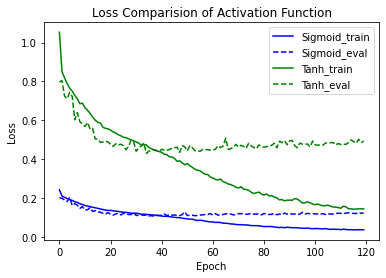

In [12]:
x=np.arange(120)
colors=[['b-','b--'],['g-','g--'],['y-','y--'],['r-','r--']]
for i in range(2):
    plt.plot(x,Losses[i][0],colors[i][0],label=names[i]+'_train')    
    plt.plot(x,Losses[i][1],colors[i][1],label=names[i]+'_eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparision of Activation Function')
plt.legend()
plt.show()

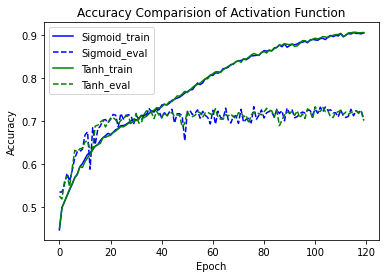

In [13]:
for i in range(2):
    plt.plot(x,Accuracies[i][0],colors[i][0],label=names[i]+'_train')    
    plt.plot(x,Accuracies[i][1],colors[i][1],label=names[i]+'_eval')
    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision of Activation Function')
plt.legend()
plt.show()

In [14]:
num_figure=8
imgs=np.arange(num_figure)*10

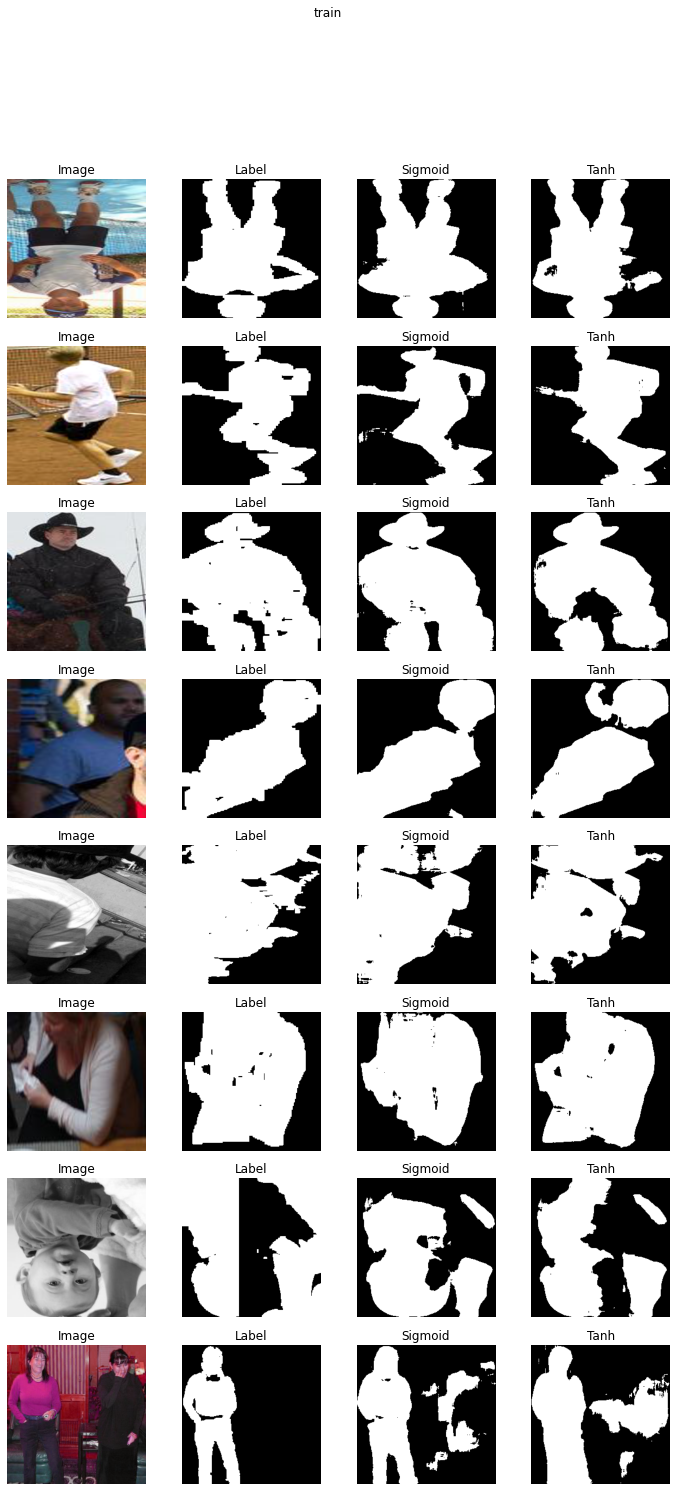

In [15]:
plt.figure(figsize=(12,24))

count=1

for i in imgs:
    
    im,label=train_data.__getitem__(i)
    
    plt.subplot(num_figure,4,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    plt.axis('off')
    plt.title('Image')
    count+=1
    
    
    plt.subplot(num_figure,4,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('Label')
    count+=1
    
    for j in range(2):
        unet = UNet(activation=act_funcs[j]).cuda()
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        plt.subplot(num_figure,4,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        mask=output.cpu().detach().numpy()[0][0]
        mask=mask>0.5 if j==0 else mask>0
        plt.imshow(mask,cmap = plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(names[j]) 
        count+=1
        del unet
plt.suptitle('train')
plt.show()

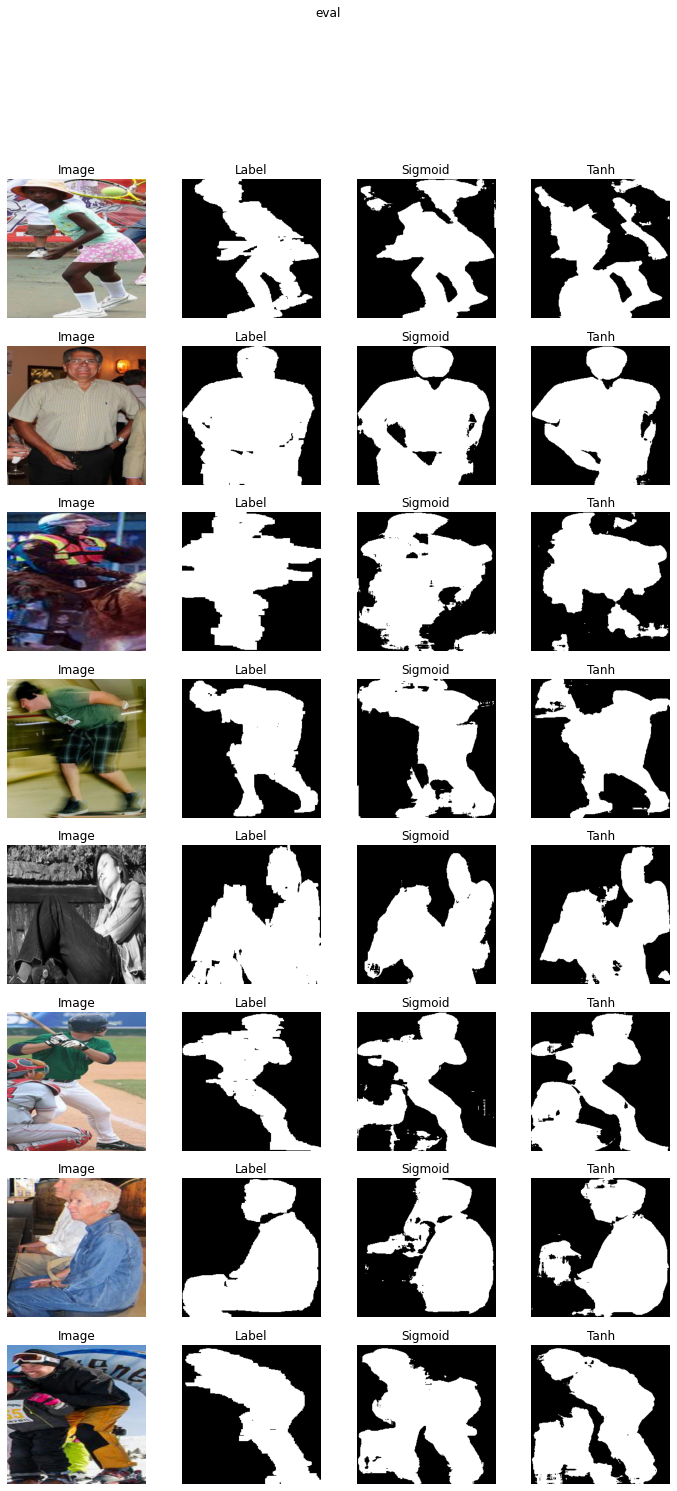

In [16]:
plt.figure(figsize=(12,24))

count=1

for i in imgs:
    
    im,label=eval_data.__getitem__(i)
    
    plt.subplot(num_figure,4,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    plt.axis('off')
    plt.title('Image')
    count+=1
    
    
    plt.subplot(num_figure,4,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('Label')
    count+=1
    
    for j in range(2):
        unet = UNet(activation=act_funcs[j]).cuda()
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        plt.subplot(num_figure,4,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        mask=output.cpu().detach().numpy()[0][0]
        mask=mask>0.5 if j==0 else mask>0
        plt.imshow(mask,cmap = plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(names[j]) 
        count+=1
        del unet
plt.suptitle('eval')
plt.show()

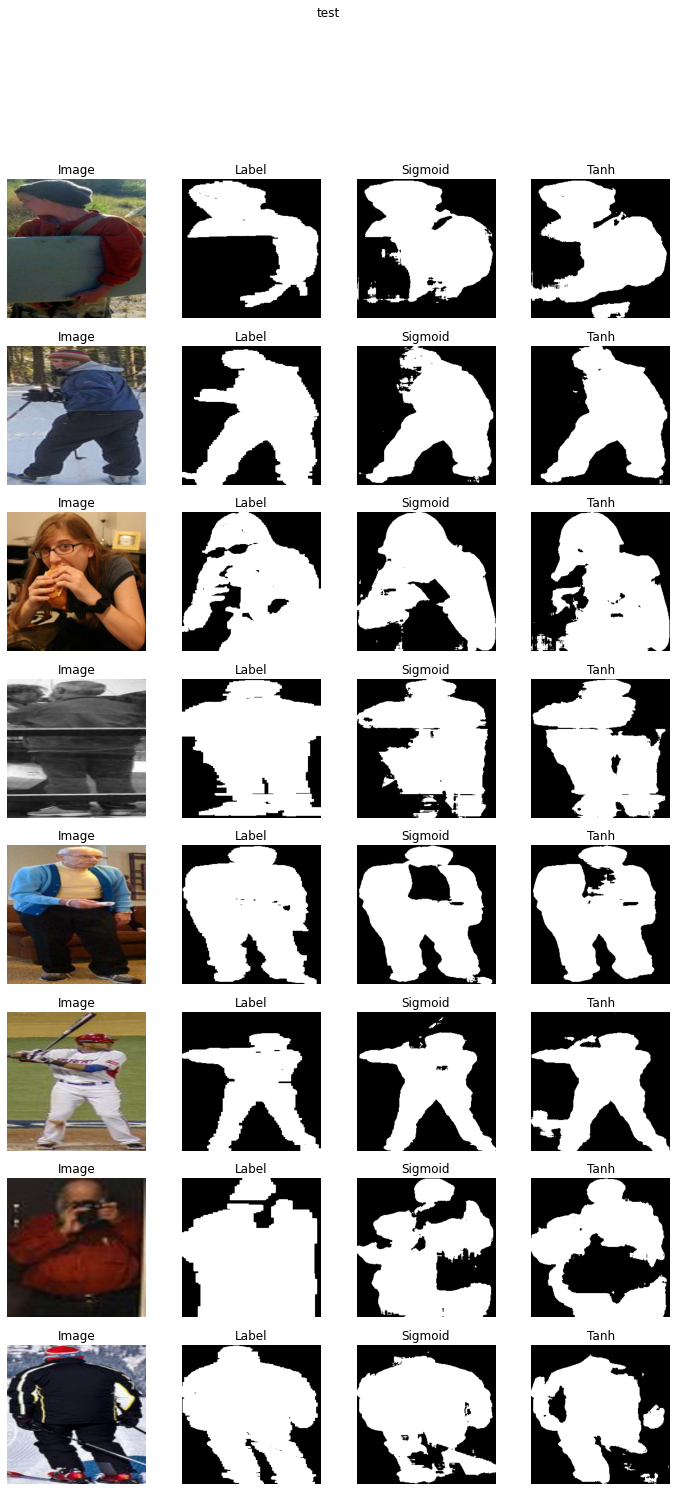

In [17]:
test_data=MyDataSet('test',test_transform[0])
plt.figure(figsize=(12,24))

count=1

for i in imgs:
    
    im,label=test_data.__getitem__(i)
    
    plt.subplot(num_figure,4,count)
    plt.imshow(np.transpose(im.numpy(),(1,2,0)))
    plt.axis('off')
    plt.title('Image')
    count+=1
    
    
    plt.subplot(num_figure,4,count)
    plt.imshow(label.numpy()[0],cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('Label')
    count+=1
    
    for j in range(2):
        unet = UNet(activation=act_funcs[j]).cuda()
        unet.load_state_dict(torch.load('./w'+str(j)+'.pkl'))
        plt.subplot(num_figure,4,count)
        img=torch.unsqueeze(im,dim=0)
        b_x=Variable(img).cuda()
        output=unet(b_x).to(torch.float64)
        mask=output.cpu().detach().numpy()[0][0]
        mask=mask>0.5 if j==0 else mask>0
        plt.imshow(mask,cmap = plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(names[j]) 
        count+=1
        del unet
plt.suptitle('test')
plt.show()